[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

## 0. Preperation

- Install latest version of SAHI and ultralytics:

In [1]:
!pip install -U torch sahi ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.w

In [2]:
import os
#os.getcwd()

- Import required modules:

In [3]:
# arrange an instance segmentation model for test
from sahi.utils.yolov8 import (
    download_yolov8s_model, download_yolov8s_seg_model
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

- Download a yolov8 model and two test images:

In [4]:
# download YOLOV5S6 model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8s.pt"
download_yolov8s_model(yolov8_model_path)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a YOLOv8 Model

- Instantiate a detection model by defining model weight path and other parameters:

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.3,
    device="cpu", # or 'cuda:0'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [6]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [7]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

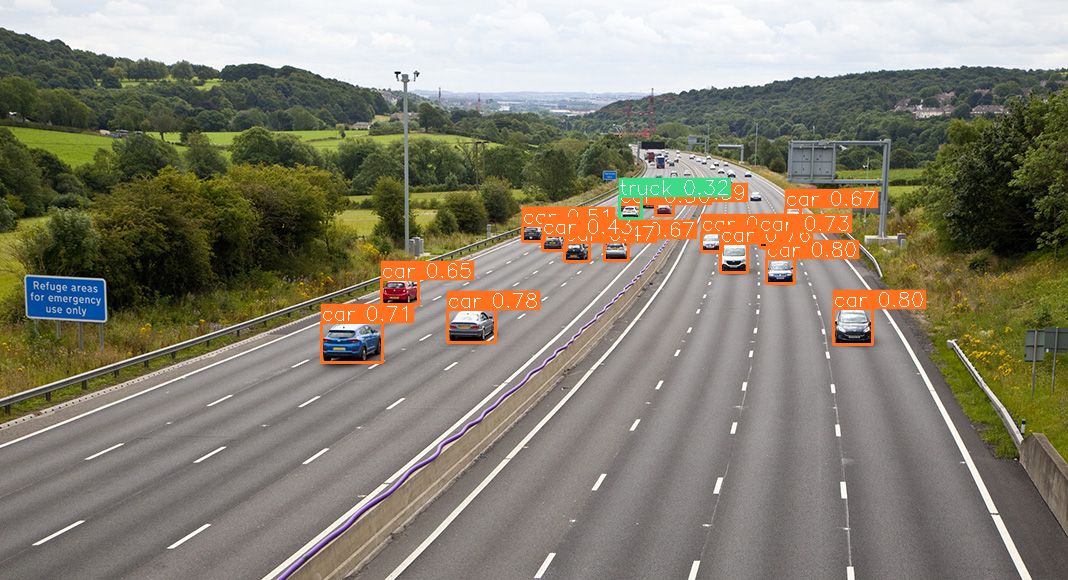

In [8]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a YOLOv8 Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [9]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 15 slices.


- Visualize predicted bounding boxes and masks over the original image:

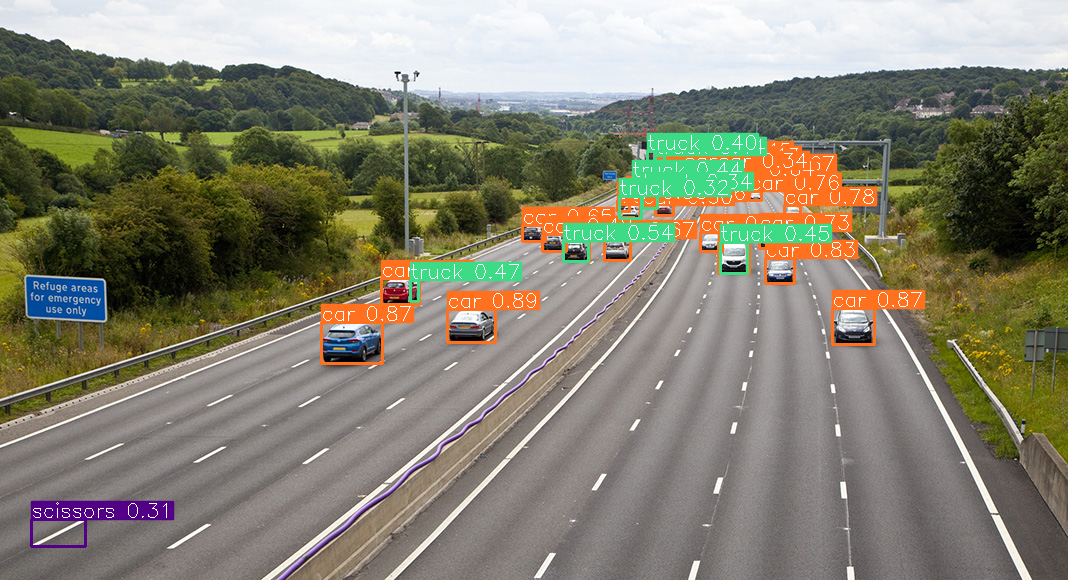

In [10]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [11]:
object_prediction_list = result.object_prediction_list

In [12]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(447.6741943359375, 309.5724792480469, 495.7220458984375, 342.0692138671875), w: 48.0478515625, h: 32.496734619140625>,
    mask: None,
    score: PredictionScore: <value: 0.885761022567749>,
    category: Category: <id: 2, name: car>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [13]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [447.6741943359375,
   309.5724792480469,
   48.0478515625,
   32.496734619140625],
  'score': 0.885761022567749,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1561},
 {'image_id': None,
  'bbox': [321.2298583984375,
   322.0831298828125,
   61.748626708984375,
   41.10981750488281],
  'score': 0.8725770115852356,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2538},
 {'image_id': None,
  'bbox': [832.658935546875,
   308.47862243652344,
   41.43067169189453,
   36.40043640136719],
  'score': 0.8661477565765381,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1508}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [14]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [447.6741943359375,
   309.5724792480469,
   48.0478515625,
   32.496734619140625],
  'score': 0.885761022567749,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1561},
 {'image_id': 1,
  'bbox': [321.2298583984375,
   322.0831298828125,
   61.748626708984375,
   41.10981750488281],
  'score': 0.8725770115852356,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2538},
 {'image_id': 1,
  'bbox': [832.658935546875,
   308.47862243652344,
   41.43067169189453,
   36.40043640136719],
  'score': 0.8661477565765381,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1508}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [15]:
!pip install -U imantics
# ImportError: Please run "pip install -U imantics" to install imantics first for imantics conversion.

  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16010 sha256=94272d8d8546ee67ddd05e2c1ce0fe65381633aecadbcca390aba5abedee6ec3
  Stored in directory: /root/.cache/pip/wheels/56/6a/be/4c60e88b14abec4e93234a1f7f91ce8abe1ae88a2b3eaad3ac
Successfully built imantics


In [16]:
result.to_imantics_annotations()[:3]

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [17]:
!pip install -U fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.9/942.9 kB 47.2 MB/s eta 0:00:0

In [18]:
result.to_fiftyone_detections()[:3]

[<Detection: {
     'id': '66b565e4445dd67f4567f84f',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.419170593947507,
         0.5337456538759429,
         0.0449886250585206,
         0.056028852791621765,
     ],
     'mask': None,
     'confidence': 0.885761022567749,
     'index': None,
 }>,
 <Detection: {
     'id': '66b565e4445dd67f4567f850',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.30077702097231973,
         0.5553157411772629,
         0.05781706620691421,
         0.07087899569807382,
     ],
     'mask': None,
     'confidence': 0.8725770115852356,
     'index': None,
 }>,
 <Detection: {
     'id': '66b565e4445dd67f4567f851',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.7796431980775983,
         0.5318596938560749,
         0.03879276375645555,
         0.0627593731058055,
     ],
     'mask': None,
     'confidence': 0.8661

## 4. Batch Prediction

- Set model and directory parameters:

In [19]:
model_type = "yolov8"
model_path = yolov8_model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.4

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [20]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  33%|███▎      | 1/3 [00:15<00:31, 15.79s/it]

Prediction time is: 15637.49 ms
Performing prediction on 15 slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:29<00:14, 14.49s/it]

Prediction time is: 13495.69 ms
Performing prediction on 20 slices.


Performing inference on images: 100%|██████████| 3/3 [00:44<00:00, 14.71s/it]

Prediction time is: 14690.12 ms
Prediction results are successfully exported to runs/predict/exp


# 0.6 Segmentation

Run above examples for segmentation model.

In [21]:
#download YOLOV8S model to 'models/yolov8s.pt'
yolov8_seg_model_path = "models/yolov8s-seg.pt"
download_yolov8s_seg_model(yolov8_seg_model_path)

In [22]:
detection_model_seg = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_seg_model_path,
    confidence_threshold=0.3,
    device="cpu", # or 'cuda:0'
)

In [23]:
im = read_image("demo_data/small-vehicles1.jpeg")
h = im.shape[0]
w = im.shape[1]

result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model_seg, full_shape=(h, w))

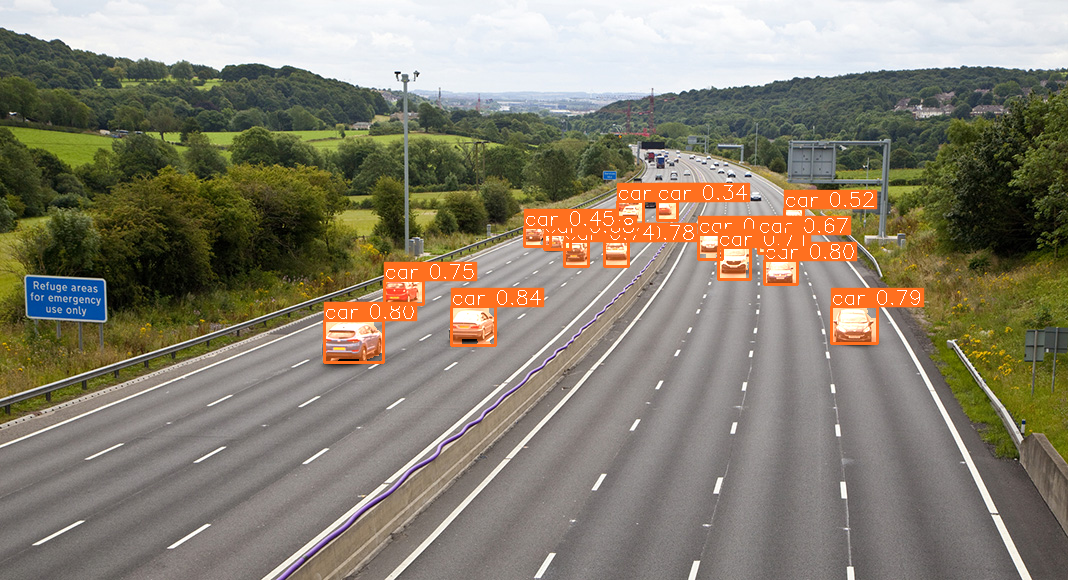

In [24]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

In [25]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model_seg,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 15 slices.


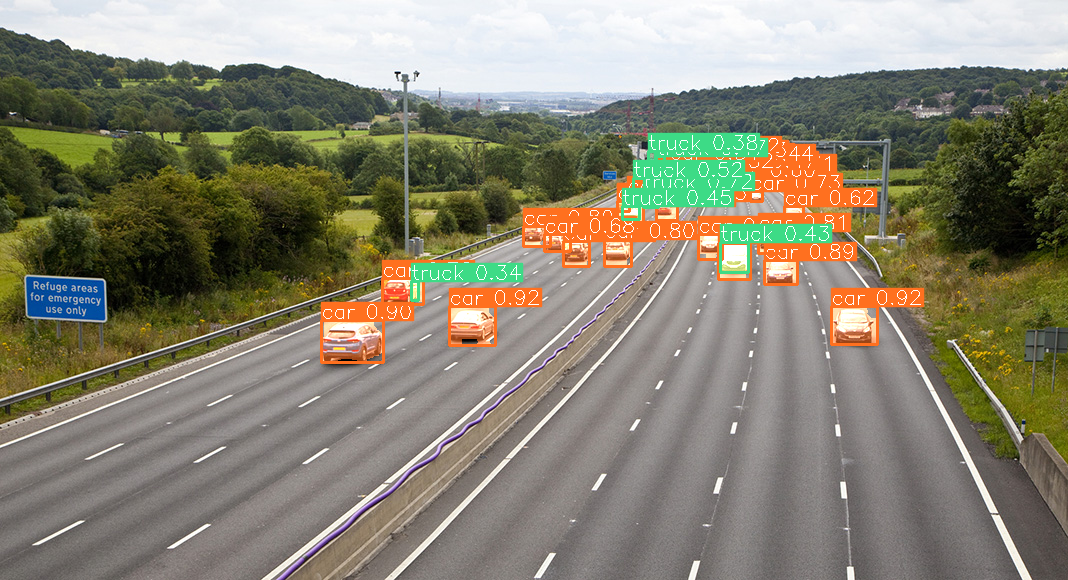

In [26]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

In [27]:
object_prediction_list = result.object_prediction_list
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(831, 306, 877, 344), w: 46, h: 38>,
    mask: <sahi.annotation.Mask object at 0x7c4c98287730>,
    score: PredictionScore: <value: 0.921109139919281>,
    category: Category: <id: 2, name: car>>

In [28]:
object_prediction_list[0].mask.segmentation

[[840,
  342,
  846,
  342,
  863,
  342,
  864,
  343,
  867,
  343,
  867,
  344,
  870,
  344,
  870,
  343,
  871,
  342,
  876,
  342,
  876,
  341,
  877,
  340,
  877,
  338,
  876,
  337,
  876,
  336,
  877,
  335,
  877,
  333,
  876,
  332,
  876,
  331,
  877,
  330,
  877,
  328,
  876,
  327,
  876,
  326,
  877,
  325,
  877,
  318,
  871,
  318,
  866,
  313,
  867,
  312,
  867,
  310,
  866,
  309,
  866,
  308,
  867,
  307,
  866,
  306,
  832,
  306,
  831,
  307,
  831,
  343,
  838,
  343,
  839,
  342]]

Sliced predictions are much better

In [29]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  33%|███▎      | 1/3 [00:11<00:23, 11.58s/it]

Prediction time is: 11505.07 ms
Performing prediction on 15 slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:22<00:11, 11.07s/it]

Prediction time is: 10637.69 ms
Performing prediction on 20 slices.


Performing inference on images: 100%|██████████| 3/3 [00:36<00:00, 12.16s/it]

Prediction time is: 14096.62 ms
Prediction results are successfully exported to runs/predict/exp2
